## Parameters

In [1]:
source_subject = "LE44" # "all"

simulate_silent_only = False

## Simulation

In [2]:
from utilsJ.regularimports import *

from utilsJ.Models import simul

from utilsJ.Models import traj

psiam_simul began


  0%|          | 0/7 [00:00<?, ?it/s]

model loaded
psiam done, generating trajectories + derivatives
getting CoM etc.


No handles with labels found to put in legend.


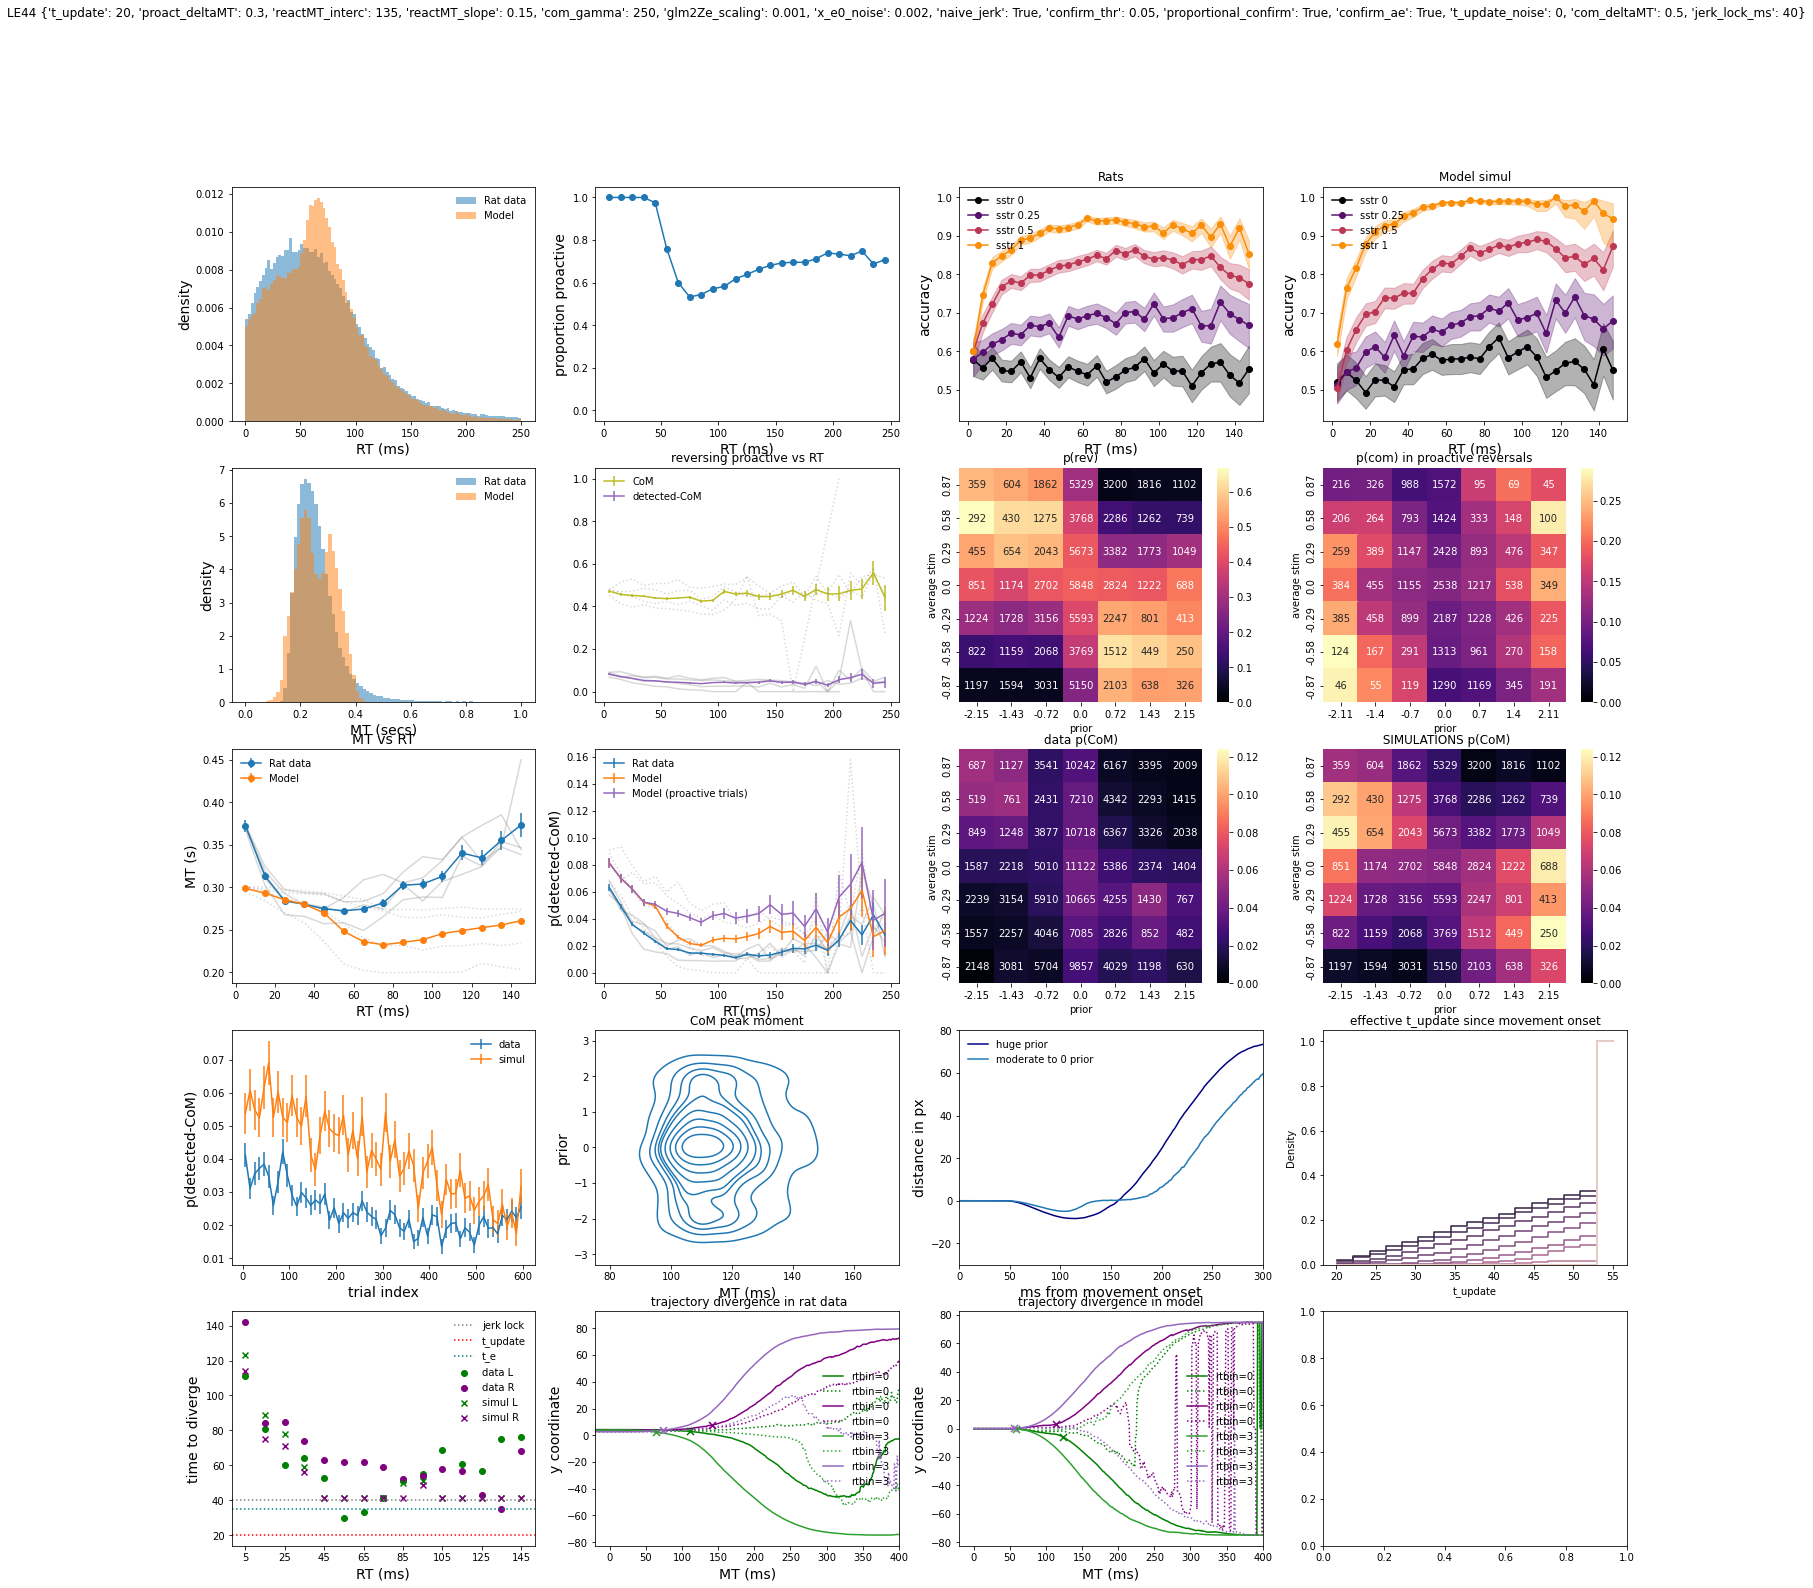

In [3]:
params = {
    "t_update": 20, 
    "proact_deltaMT": 0.3, # 0.2
    "reactMT_interc": 135, 
    "reactMT_slope": 0.15,
    "com_gamma": 250, 
    "glm2Ze_scaling": 0.001, 
    "x_e0_noise": .002,
    "naive_jerk": True, 
    "confirm_thr": 0.05,
    "proportional_confirm": True,
    "confirm_ae": True,
    "t_update_noise": 0,
    "com_deltaMT": 0.5,
    "jerk_lock_ms": 40
}

arguments = {
    "params": params,
    "return_matrices": True,
    "vanishing_bounds": False,
    "both_traj": False,
    "trajMT_jerk_extension": 0,
    "com_height": 5,
    "mtnoise": 0.5,
    "drift_multiplier": np.array([1,1.5,2.5,2.5]),
    "extra_t_0_e": 0.015,
    "sample_silent_only": simulate_silent_only,
    "silent_trials": simulate_silent_only
}

# if "df" in vars():
#     arguments["dfpath"] = df

df, out, e_mat_list, u_mat_list = simul.whole_simul(source_subject, **arguments)

In [4]:
e_mat = np.vstack(e_mat_list)
u_mat = np.vstack(u_mat_list)

## Generation of trajectory stamps

In [5]:
timestep = np.timedelta64("1000", "us")

fixation_onset = pd.to_datetime(pd.Timestamp.min, "us")

fixation_end = fixation_onset + np.timedelta64("300000", "us") # 300 ms

def trajectory_stamp(row):
    trajectory = row["traj"]
    
    sound_length = pd.to_timedelta(row["sound_len"]*1000, unit = "us")
    
    start = fixation_end + sound_length
    
    end = start + len(trajectory)*timestep
    
    stamp = np.arange(start, end, timestep)
    
    return stamp

## Modify some output columns

In [6]:
simulation = out.copy()

simulation["subjid"] = "SIMULATION"

simulation["special_trial"] = 2 if simulate_silent_only else 0

simulation["framerate"] = 1000

simulation["fix_onset_dt"] = fixation_onset

simulation["trajectory_stamps"] = simulation.apply(trajectory_stamp, axis = 1)

## Import paper figures

In [7]:
sys.path.append("custom_utils/UtilsJ/paperfigs")

import fig3

## Median trajectory x prior bin

In [8]:
if simulate_silent_only:
    fig3.a(simulation.copy(), average=True, trajectory="traj", velocity="traj_d1")

    fig3.a(df.copy(), average=True)

## Median trajectory x evidence bin

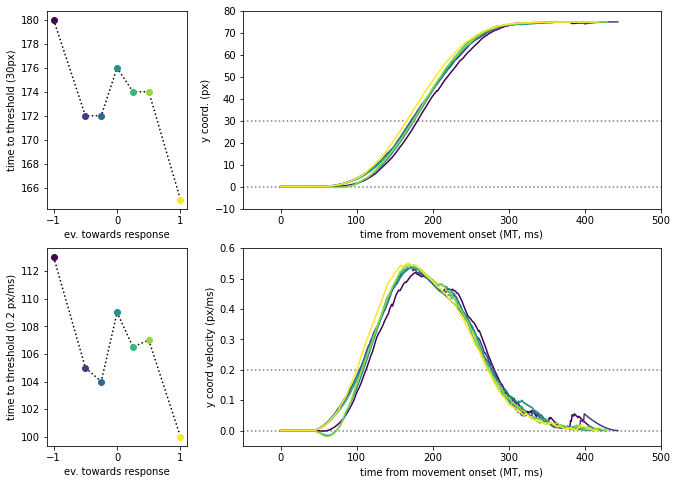

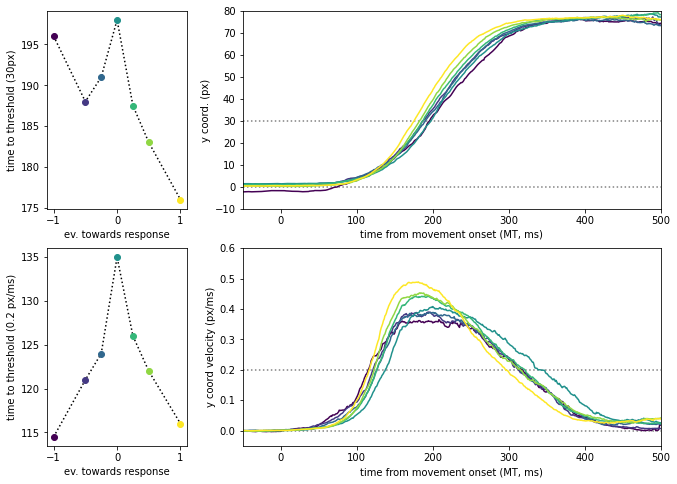

In [9]:
fig3.b(simulation.copy(), average=True, trajectory="traj", velocity="traj_d1")

fig3.b(df.copy(), average=True)

## Divergence time x reaction time

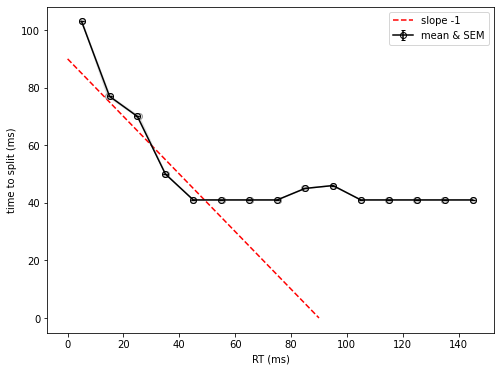

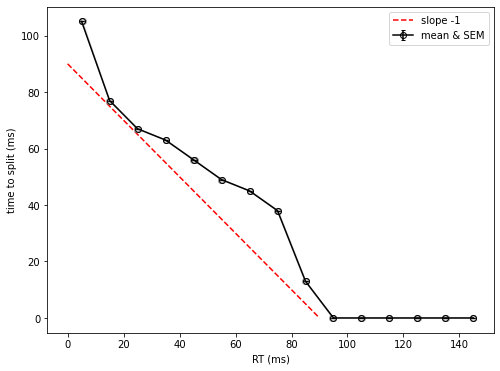

In [10]:
fig3.d(simulation.copy(), trajectory="traj")

fig3.d(df.copy())

## Raw traces

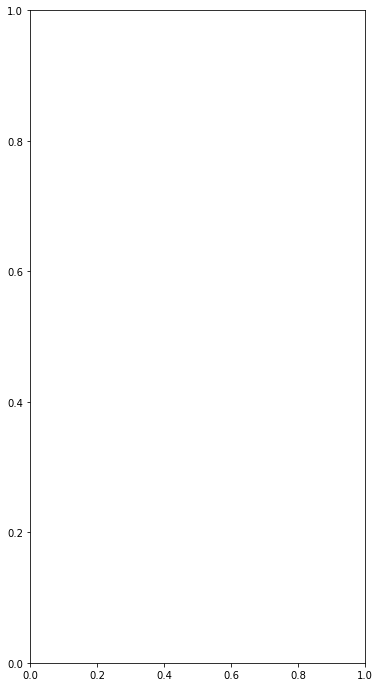

In [11]:
f, ax = plt.subplots(figsize=(6,12))

def draw_raw(indx, out=None, emat=None, ax=None, t_e=40, a_e=0.495, scale=100, alpha=0.5):
    for i in indx:
        slen = int(out.loc[i, 'sound_len']*10)
        # check whether it hits the bound first
        try:
            bh = np.argmax(np.abs(emat[i, :slen])>a_e)
        except:
            bh=0
        if bh:
            slen = bh
        ax.plot(np.arange(slen)/10-slen/10+t_e, emat[i, :slen]*scale+130, c='k', alpha=alpha, linewidth=1)
        
        traj = out.loc[i, 'traj']
        tup = int(out.loc[i, 't_update'])
        rlen = int(out.loc[i, 'resp_len']*1000)

        ax.plot(np.arange(rlen)[:tup], traj[:tup], c='navy')
        if not out.loc[i, 'rev']: # confirm
            upcolor = 'tab:blue'
        elif out.loc[i, 'CoM_sugg']:
            upcolor = 'tab:olive'
        else:
            upcolor = 'tab:purple'

        ax.plot(np.arange(rlen)[tup:], traj[tup:], c=upcolor, alpha=alpha)
        ax.scatter(np.arange(rlen)[tup], traj[tup], c=upcolor, marker='x', alpha=alpha)
    ax.axhline(a_e*scale+130, color='purple', zorder=0)
    ax.axhline(0+130, color='gray', ls=':', zorder=0)
    ax.axhline(-a_e*scale+130, color='g', zorder=0)
    ax.axhline(0, color='gray', ls=':', zorder=0)
    ax.set_ylim(-80, 180)
    ax.yaxis.set_visible(False)

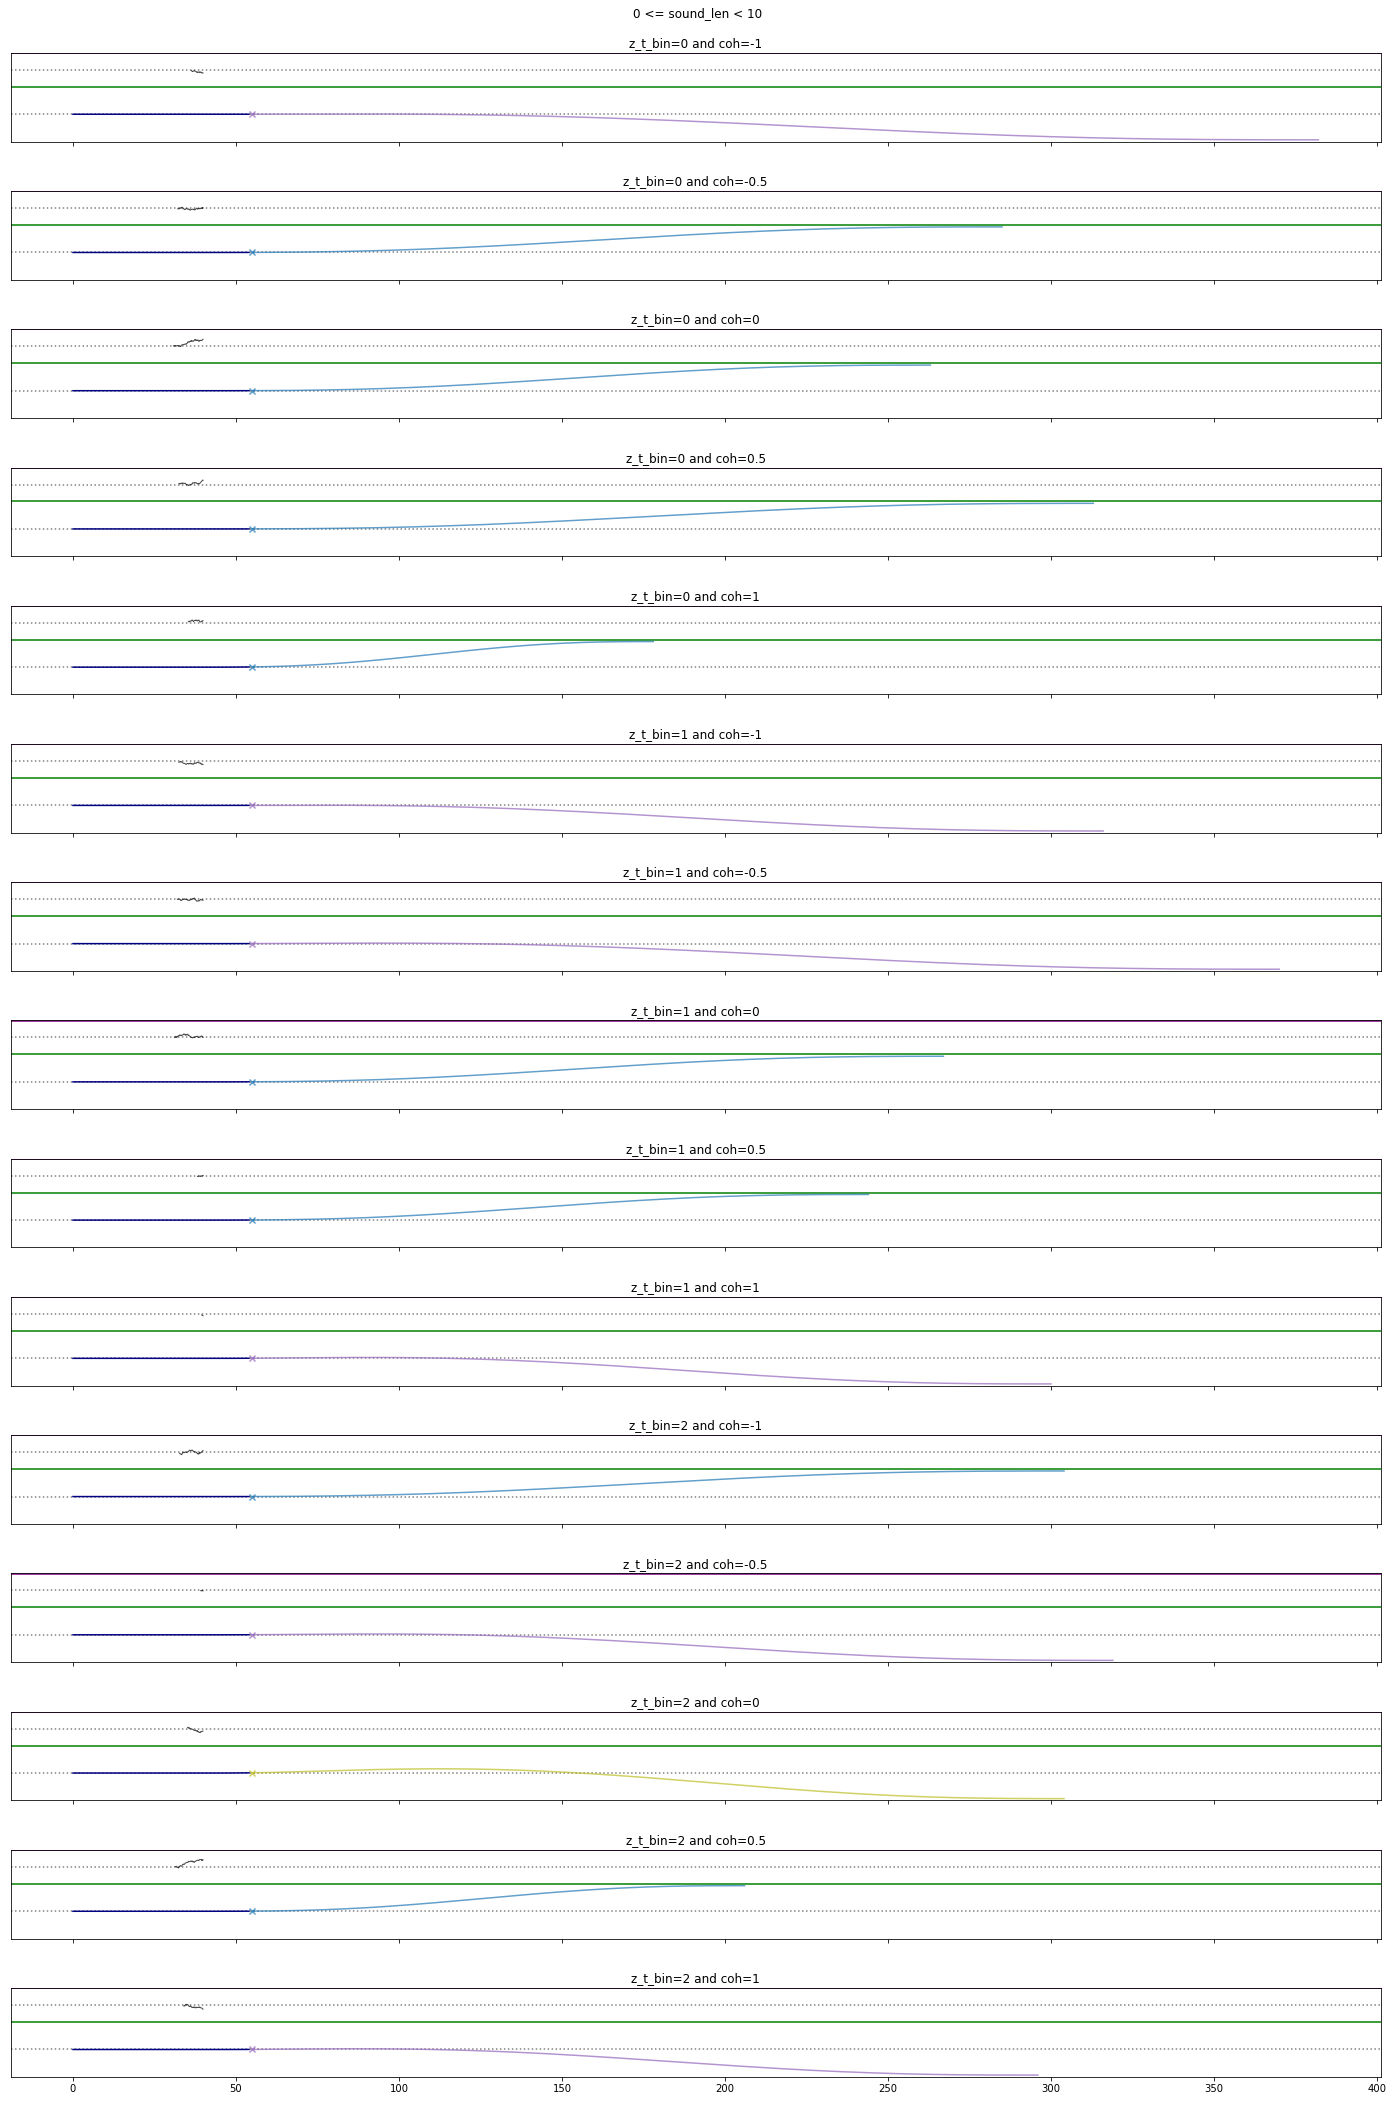

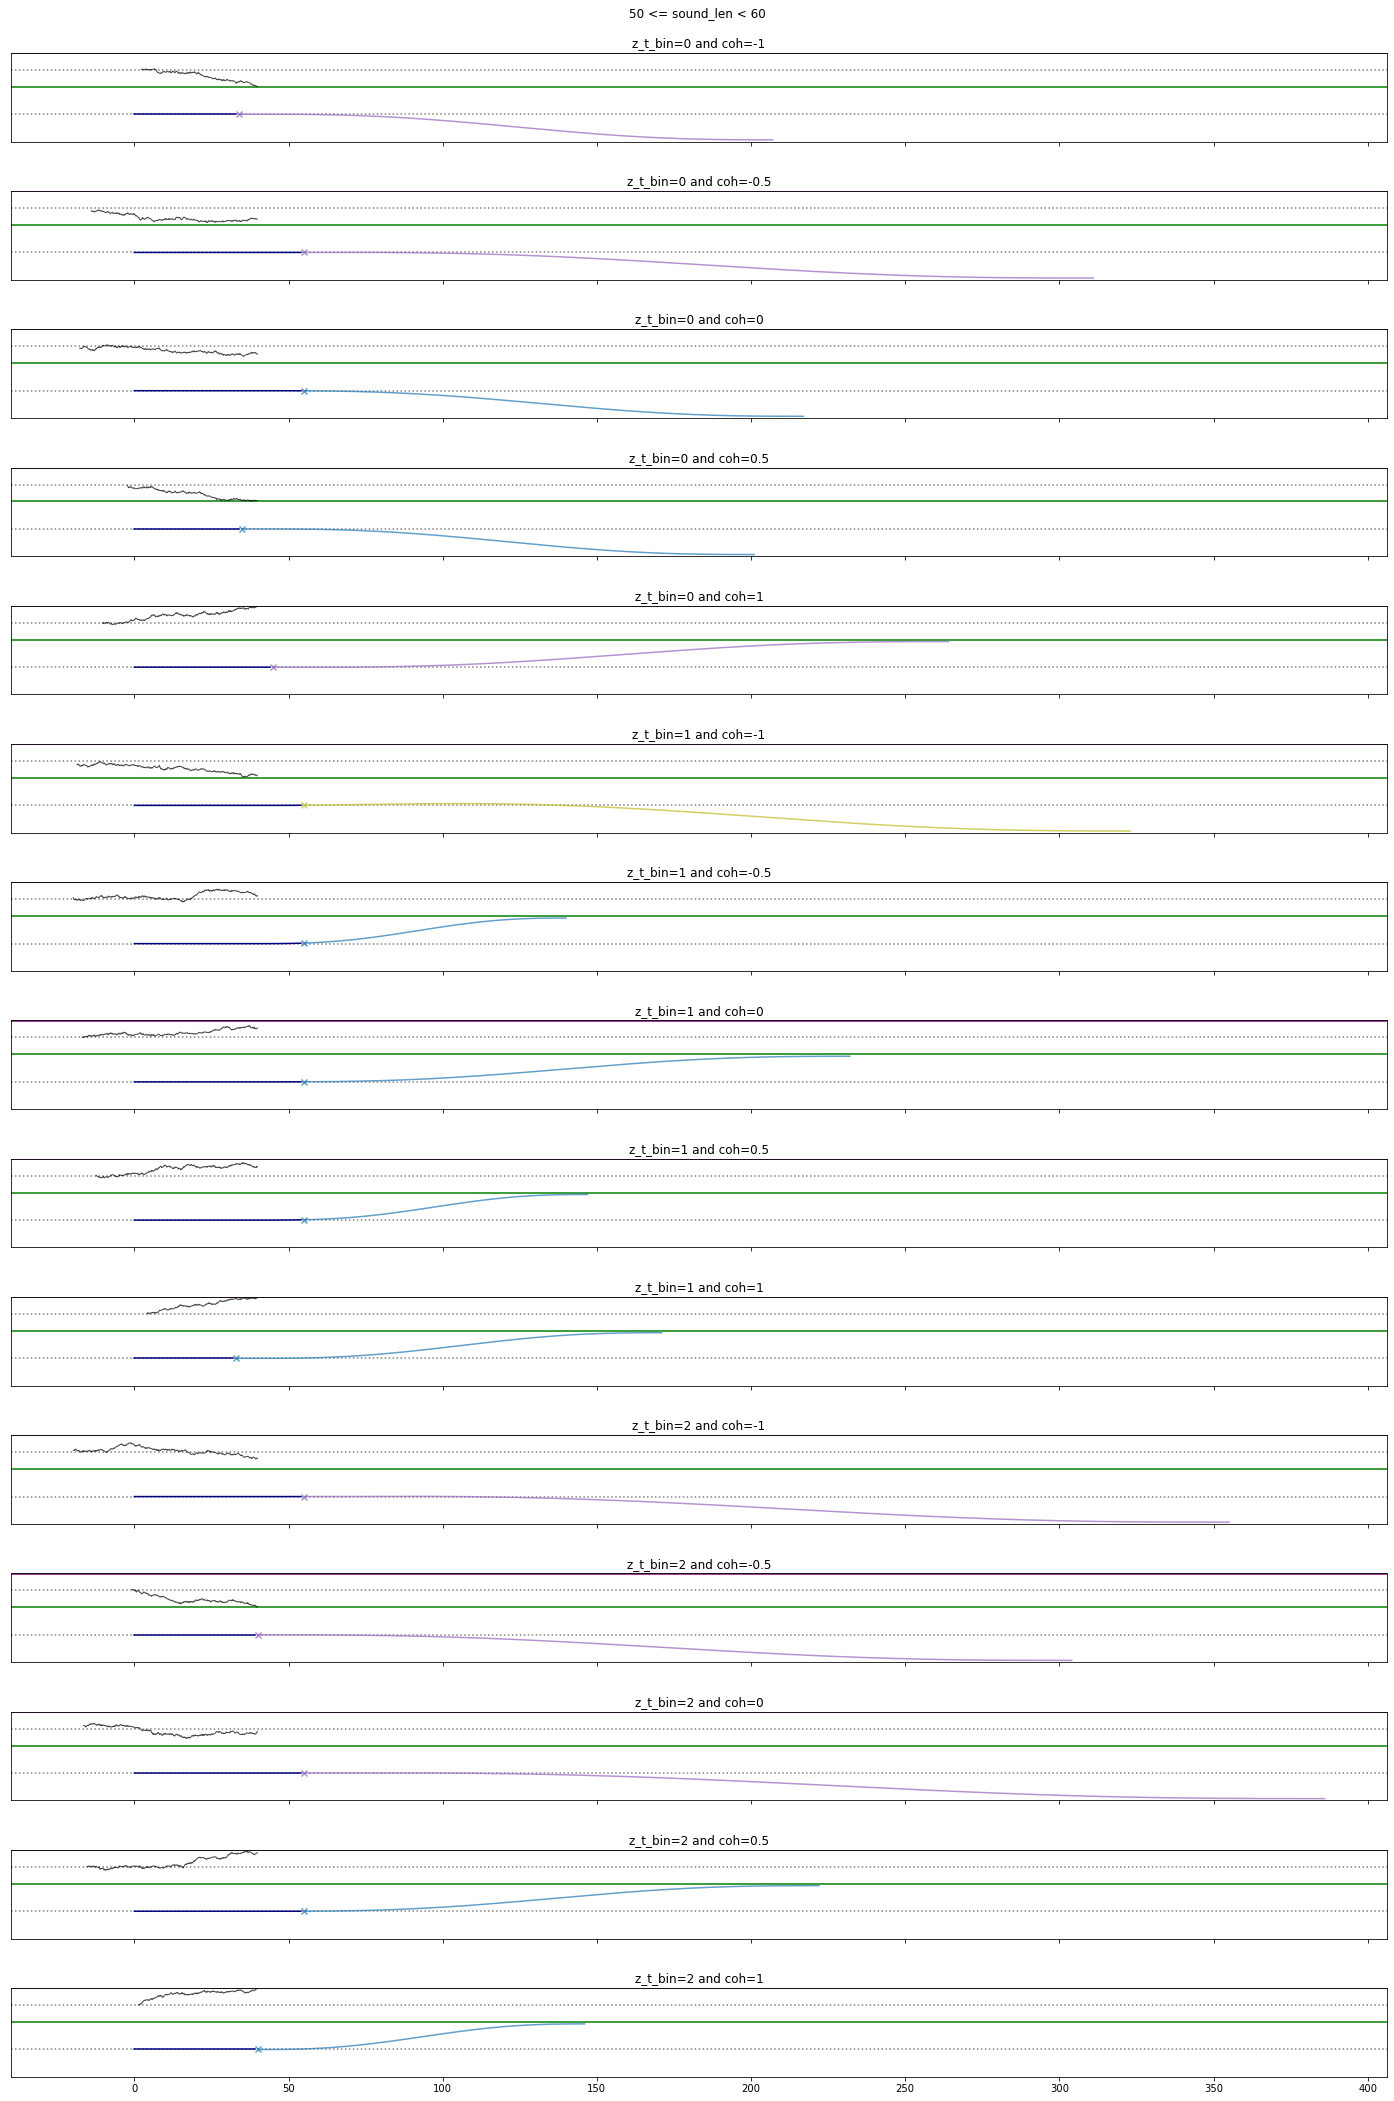

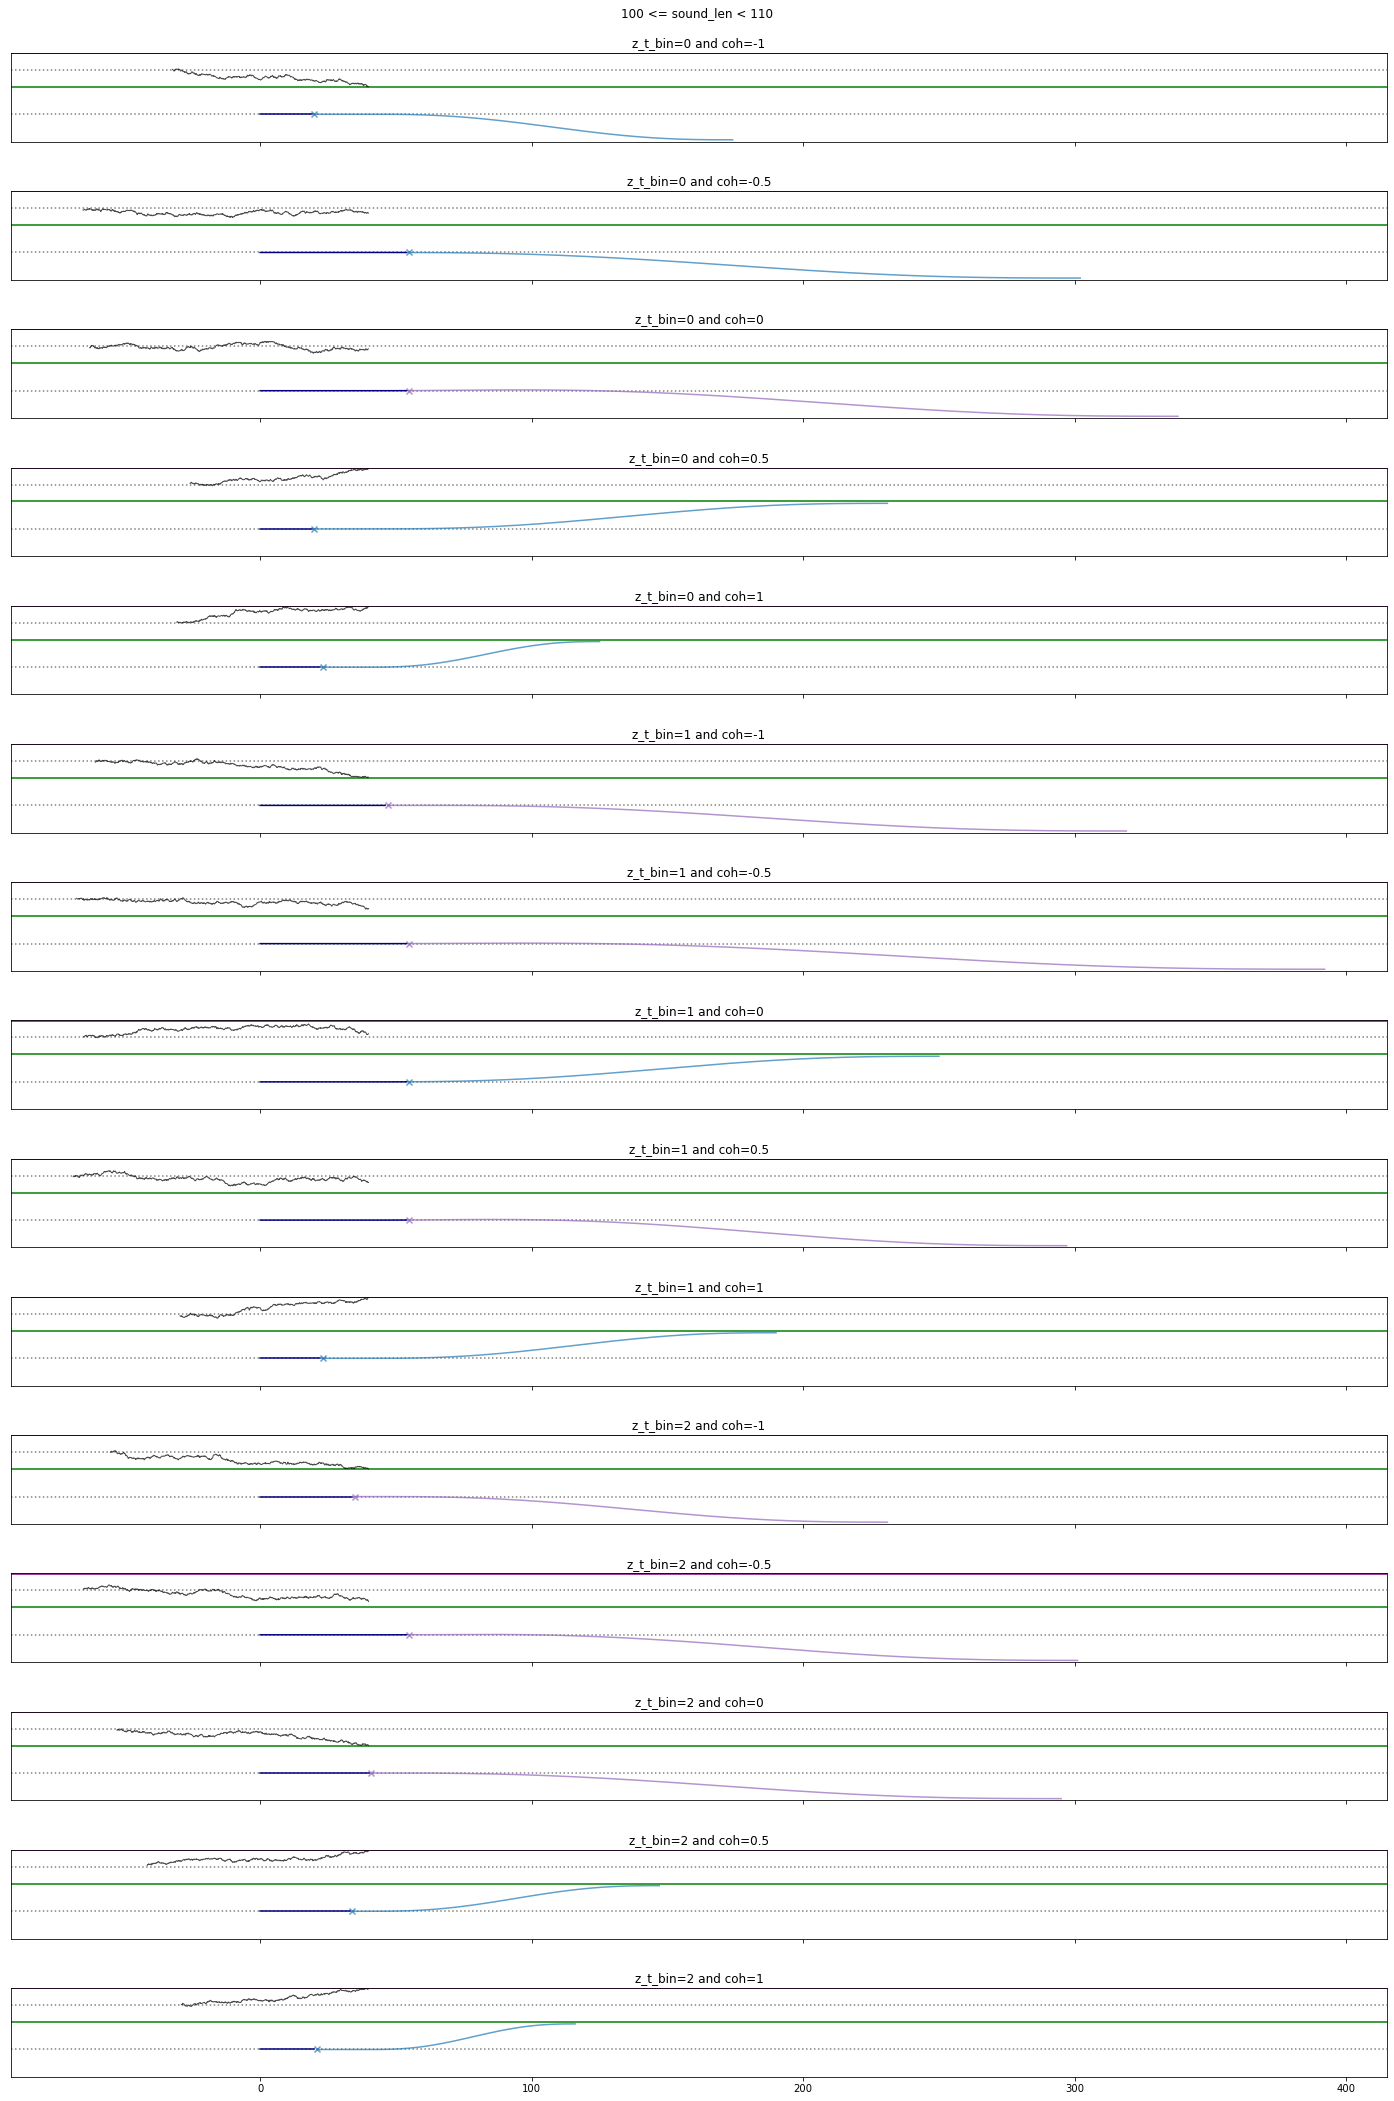

In [12]:
raw = simulation.copy()

raw_draw_count = 1

raw['z_t_bin']= np.nan
raw.loc[(raw.allpriors>=0)&(raw.allpriors<0.5),'z_t_bin'] = 0
raw.loc[(raw.allpriors>=0.5)&(raw.allpriors<1),'z_t_bin'] = 1
raw.loc[(raw.allpriors>=1),'z_t_bin'] = 2

for rt in [0,50,100]:
    f, ax = plt.subplots(nrows=15, figsize=(20,30), sharex=True, sharey=False)
    
    plt.suptitle(f'{rt} <= sound_len < {rt + 10}')
    
    index = 0
    
    for j, ztbin in enumerate([0,1,2]):
        for i,coh in enumerate([-1, -0.5, 0, 0.5, 1]):
            cdf = raw.loc[(raw.reactive==0)&(raw.sound_len>=rt) &(raw.sound_len<rt+10) & (raw.z_t_bin==ztbin)&(raw.coh2==coh)]
            
            if len(cdf)>raw_draw_count:
                draw_raw(cdf.index[:raw_draw_count], out=raw, emat=e_mat, ax=ax[index], alpha=.7)
            else:
                draw_raw(cdf.index, out=raw, emat=e_mat, ax=ax[index], alpha=.7)
            ax[index].set_title(f'z_t_bin={ztbin} and coh={coh}')
            
            index += 1
    
    f.tight_layout(pad = 3)
    
    plt.show()